Figure 3: Shock predicting cell co-firing stifled by ANI administration

In [1]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg
from copy import copy, deepcopy
from tqdm import tqdm
import platform

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova
from stats_utils import resample, bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired
from subjects import save_df, load_df

In [2]:
group_data_dir = "/Users/nkinsky/Documents/BU/Working/Eraser" if platform.system() == "Darwin" else "/home/nkinsky/Dropbox (University of Michigan)/Eraser/GroupData"
group_data_dir = Path(group_data_dir)
print(group_data_dir)

/Users/nkinsky/Documents/BU/Working/Eraser


In [3]:
def add_memory_designations(df_use, key_use="d1_d2", before=['-2_-1', '-1_4'], during=['4_1'], 
                            after=['1_2', '2_7'], designation_key='Designation'):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)

    for key_val in before:
        df.loc[df[key_use] == key_val, designation_key] = "Before"

    for key_val in during:
        df.loc[df[key_use] == key_val, designation_key] = "4hr"

    for key_val in after:
        df.loc[df[key_use] == key_val, designation_key] = "After"
    
    return df
file_name = "cov_sigz_freeze_df_all"
df_use = load_df(file_name, save_dir=group_data_dir)
add_memory_designations(df_use)

,Mouse,d1_d2,covz,Group,Designation
0,Marble07,-2_-1,0.196919,Learners,Before
1,Marble07,-2_-1,0.476621,Learners,Before
2,Marble07,-2_-1,2.132457,Learners,Before
3,Marble07,-2_-1,1.297199,Learners,Before
4,Marble07,-2_-1,2.399505,Learners,Before
...,...,...,...,...,...
96883,Marble25,4_2,4.705136,ANI,NaN
96884,Marble25,4_2,0.656961,ANI,NaN
96885,Marble25,4_2,-0.661020,ANI,NaN
96886,Marble25,4_2,3.624170,ANI,NaN


In [210]:
%matplotlib ipympl
Fig3 = Fig(num=3, grid=(5, 4), size=(8.5, 8.0), fontsize=6, constrained_layout=False, tight_layout=True)  # size=(7.2, 5.3) if not scaling properly
print(Fig3.fig.get_size_inches())
Fig3stats = Fig(num="Figure 3 stats", grid=(5, 4), size=(8.5, 6.5), fontsize=6, constrained_layout=False, 
                tight_layout=True)
print(Fig3stats.fig.get_size_inches())
Fig3comb = FigMirror(Fig3, Fig3stats)

[8.5 8. ]
[8.5 6.5]


In [211]:
%matplotlib ipympl
FigS6 = Fig(num="S6", grid=(6, 4), size=(8.5, 9.6), tight_layout=True, constrained_layout=False, fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(FigS6.fig.get_size_inches())
FigS6stats = Fig(num="Figure S6 stats", grid=(6, 4), size=(8.5, 9.6), tight_layout=True, constrained_layout=False, fontsize=6) 
print(FigS6stats.fig.get_size_inches())
FigS6comb = FigMirror(FigS6, FigS6stats)

[8.5 9.6]
[8.5 9.6]


In [6]:
# IMPORTANT - use consistent times before/after freeze onset to find and analyze freeze predictive cells
# Note that 2 seconds before/after (buffer_sec=(2, 2)) is the default used for all calculations and .pkl files saved
# in .pkl files unless otherwise designated.
buffer_sec_use = (4, 4)  # use this to find significance
buffer_sec_plot = (4, 4)  # use this for plotting to show that the relevant window of activity is actually +/- 2 sec
# and that 2-4 sec prior activity is closer to baseline

bin_size = 0.5 # sec, for covariance analysis

### First, plot example freezing cells from Marble07: 53, 67, 90, and 334

In [ ]:
mmd = fa.MotionTuningMultiDay('Marble07', arena='Shock', days=[-1, 4, 1, 2], 
                              buffer_sec=buffer_sec_plot)

In [ ]:
# Example raster side-by-side for sanity check on high covariance of these two cells
_, ax = plt.subplots(1, 2)
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][334], ax=ax[0])
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][53], ax=ax[1])

### 3A: Plot example traces from freeze-tuned cells. Blue = 53, Pink = 334.

In [ ]:
# Plot example traces from freeze-tuned cells. Blue = 53, Pink = 334.
ax_ex_cell_cofire = Fig3.subplot2grid(Fig3.gs[0, 0:3], grid=(1, 2), return_axes=True)
neurons_plot = [53, 334]
im_data = sio.loadmat(mmd.motion_tuning['Shock'][1].dir_use / 'FinalOutput.mat')
rawtraces = im_data['NeuronTraces']['RawTrace'].squeeze().item()
rawtraces = rawtraces[:, :mmd.motion_tuning['Shock'][1].PSAbool.shape[1]]  # Align rawtraces with PSAbool
rawz = (rawtraces - rawtraces.mean(axis=1)[:, None])/rawtraces.std(axis=1)[:, None]
psabool = mmd.motion_tuning['Shock'][1].PSAbool
t = np.arange(0, mmd.motion_tuning['Shock'][1].PSAbool.shape[1])/mmd.motion_tuning['Shock'][1].sr_image
for ax, xlim in zip(ax_ex_cell_cofire, ([265, 290], [340, 380])):
    for psa, trace in zip(psabool[[neurons_plot]].astype(bool).squeeze(), rawz[[neurons_plot]].squeeze()):
        ax.plot(t, trace)
        for event_idx in contiguous_regions(psa):
            ax.plot(t[event_idx[0]:event_idx[1]], trace[event_idx[0]:event_idx[1]], 'r')

    for ftimes in mmd.motion_tuning['Shock'][1].freezing_times:
        ax.axvspan(ftimes[0], ftimes[1], color=[0, 1, 0, 0.3])

    ax.set_xlim(xlim)
    ax.set_frame_on(True)

In [ ]:
# Plot heatmaps as sanity check - these aren't just overlapping place cells. 
# Rather, they fire in a lot of different places
PF = pf.load_pf('Marble07', 'Shock', 1)
_, ax = plt.subplots(1, 2, figsize=(6, 3))
for a, nid in zip(ax, neurons_plot):
    sns.heatmap(PF.tmap_sm[nid], ax=a)

### 3C and S6K-L: Plot PBE examples - all cell coactivity around time of freezing

In [ ]:
# Set up PBE dataframes
buffer_plot = (4, 4)
PBElearn = cova.get_group_PBE_rasters(err.learners, 'Learners', buffer_sec=buffer_plot)
PBEnlearn = cova.get_group_PBE_rasters(err.nonlearners, 'Non-Learners', buffer_sec=buffer_plot)
PBEani = cova.get_group_PBE_rasters(err.ani_mice_good, 'ANI', buffer_sec=buffer_plot)

control_mice_good = copy(err.learners)
control_mice_good.extend(err.nonlearners)
PBEctrl = cova.get_group_PBE_rasters(control_mice_good, 'Control', buffer_sec=buffer_plot)

# Now combine and simplify data
PBEcomb, PBEcomb_simp = {}, {}
for day in [-2, -1, 4, 1, 2]:
    PBEcomb[day] = pd.concat([PBElearn[day], PBEnlearn[day], PBEani[day]])
    PBEcomb_simp[day] = pd.concat([PBEctrl[day], PBEani[day]])

# Add in memory/group designations to dataframe
PBEcomb_simp2 = add_memory_designations(pd.concat(PBEcomb_simp.values()), key_use="day",
                                       before=[-2, -1], during=[4], after=[1, 2])
PBEcomb = add_memory_designations(pd.concat(PBEcomb.values()), key_use="day",
                                       before=[-2, -1], during=[4], after=[1, 2])

In [ ]:
np.hstack((ax, ax))

In [ ]:
# Plot PBEs with 3 groups for reference
alpha = 0.05

cmap_3grps = plt.get_cmap('Set2').colors

_, ax = plt.subplots(1, 3, figsize=(10, 3))
ax_aft_3grps, _ = FigS6comb.subplot(FigS6.gs[3, 3])

for ida, (a, desig) in enumerate(zip(np.hstack((ax, ax_aft_3grps)), ['Before', '4hr', 'After', 'After'])):

    PBEcomb_use = PBEcomb if ida < 3 else PBEcomb[PBEcomb.group != 'ANI']
    sns.lineplot(data=PBEcomb_use[PBEcomb_use['Designation'] == desig], palette=cmap_3grps, dashes=["", (2.5, 1)],
                                    x='times', y='act_neuron_ratio_z', hue='group', style='group', ax=a)

    a.set_xlabel('Time from freeze start (s)')
    a.set_ylabel(r'$Z_{nactive}$')
    a.set_title(desig)


In [ ]:
# Now plot PBEs
alpha = 0.05

cmap_2grps = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap
ax_pbe_bef, _ = FigS6comb.subplot(FigS6.gs[3, 2])
ax_pbe_4hr, _ = FigS6comb.subplot(FigS6.gs[3, 3])
ax_pbe_aft, _ = Fig3comb.subplot(544)

for a, desig in zip([ax_pbe_bef, ax_pbe_4hr, ax_pbe_aft], ['Before', '4hr', 'After']):
    sns.lineplot(data=PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig], palette=cmap_2grps, dashes=["", (2.5, 1)],
                                    x='times', y='act_neuron_ratio_z', hue='group', style='group', ax=a)
    
    # Get sig bins and plot
    p_t, tstat_t = [], []
    for timept in np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times']):
        time_bool = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'] == timept
        df_tpt = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig][time_bool]
        control_bool = df_tpt['group'] == 'Control'
        ani_bool = df_tpt['group'] == 'ANI'
        tstat, p = s.ttest_ind(df_tpt[control_bool]['act_neuron_ratio_z'],
                                   df_tpt[ani_bool]['act_neuron_ratio_z'])
        p_t.append(p)
        tstat_t.append(tstat)
    
    # Plot sig

    times_plot = np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'])
    sigbool = np.array(p_t) < alpha
    ylim = a.get_ylim()
    a.plot(times_plot[sigbool], np.ones(np.sum(sigbool))*ylim[1]*0.9, 'r.')
    a.set_xlabel('Time from freeze start (s)')
    a.set_ylabel(r'$Z_{nactive}$')
    a.set_title(desig)


#### Plot PBEs in Neutral arena for reference
They do not display the same uptick prior to freezing/immobility following conditioning as do cells in the Shock arena

In [ ]:
# Set up PBE dataframes
buffer_plot = (4, 4)
PBElearn = cova.get_group_PBE_rasters(err.learners, 'Learners', buffer_sec=buffer_plot, arena='Open')
PBEnlearn = cova.get_group_PBE_rasters(err.nonlearners, 'Non-Learners', buffer_sec=buffer_plot, arena='Open')
PBEani = cova.get_group_PBE_rasters(err.ani_mice_good, 'ANI', buffer_sec=buffer_plot, arena='Open')

control_mice_good = copy(err.learners)
control_mice_good.extend(err.nonlearners)
PBEctrl = cova.get_group_PBE_rasters(control_mice_good, 'Control', buffer_sec=buffer_plot)

# Now combine and simplify data
PBEcomb, PBEcomb_simp = {}, {}
for day in [-2, -1, 4, 1, 2]:
    PBEcomb[day] = pd.concat([PBElearn[day], PBEnlearn[day], PBEani[day]])
    PBEcomb_simp[day] = pd.concat([PBEctrl[day], PBEani[day]])

# Add in memory/group designations to dataframe
PBEcomb_simp2 = add_memory_designations(pd.concat(PBEcomb_simp.values()), key_use="day",
                                       before=[-2, -1], during=[4], after=[1, 2])

In [ ]:
# Now plot PBEs
alpha = 0.05

cmap_2grps = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap
_, ax = plt.subplots(1, 3, figsize=(9, 3))
ax_pbe_bef, ax_pbe_4hr, ax_pbe_aft = ax

for a, desig in zip([ax_pbe_bef, ax_pbe_4hr, ax_pbe_aft], ['Before', '4hr', 'After']):
    sns.lineplot(data=PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig], palette=cmap_2grps, dashes=["", (2.5, 1)],
                                    x='times', y='act_neuron_ratio_z', hue='group', style='group', ax=a)
    
    # Get sig bins and plot
    p_t, tstat_t = [], []
    for timept in np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times']):
        time_bool = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'] == timept
        df_tpt = PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig][time_bool]
        control_bool = df_tpt['group'] == 'Control'
        ani_bool = df_tpt['group'] == 'ANI'
        tstat, p = s.ttest_ind(df_tpt[control_bool]['act_neuron_ratio_z'],
                                   df_tpt[ani_bool]['act_neuron_ratio_z'])
        p_t.append(p)
        tstat_t.append(tstat)
    
    # Plot sig

    times_plot = np.unique(PBEcomb_simp2[PBEcomb_simp2['Designation'] == desig]['times'])
    sigbool = np.array(p_t) < alpha
    ylim = a.get_ylim()
    a.plot(times_plot[sigbool], np.ones(np.sum(sigbool))*ylim[1]*0.9, 'r.')
    a.set_xlabel('Time from freeze start (s)')
    a.set_ylabel(r'$Z_{nactive}$')
    a.set_title(desig)

### 3D-F and S6A-C: example freeze tuned cells across days

In [ ]:
# Other example cell for supplemental - Non-Learner
axnonlrncell, axnonlrncell_stats = FigS6comb.subplot2grid(FigS6.gs[0, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble11', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(584, base_day=1, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                            plot_ROI=False, ax=axnonlrncell, rasterized=True)

In [ ]:
# Other example cell for supplemental - Learner
axlrncell3, axlrncell3_stats = FigS6comb.subplot2grid(FigS6.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble24', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(36, base_day=1, base_arena='Shock', batch_map=False, 
                            smooth_sec=0.5, plot_ROI=False, ax=axlrncell3, rasterized=True)

In [ ]:
# Maybe better learner cell?
axlrncella, axlrncella_stats = Fig3comb.subplot2grid(Fig3.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(334, base_day=1, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                            plot_ROI=False, ax=axlrncella.squeeze(), label_fig=False, rasterized=True)

In [ ]:
mmd.plot_raster_across_days(53, base_day=1, base_arena='Shock', batch_map=False,
                           plot_ROI=False, label_fig=False, rasterized=True, smooth_sec=0.5) 

In [ ]:
# Example learner cell from same sessions as first second row
axlrncellb, axlrncellb_stats = Fig3comb.subplot2grid(Fig3.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(53, base_day=1, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                           plot_ROI=False, ax=axlrncellb.squeeze(), label_fig=False, rasterized=True) 

In [ ]:
# Example unstable ANI cell
# Need to update this to look out +/- 2 sec due to different frame rate
axanicell, axanicell_stats = Fig3comb.subplot2grid(Fig3.gs[3, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble20', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(2, base_day=4, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                           plot_ROI=False, ax=axanicell.squeeze(), label_fig=False, rasterized=True)

In [ ]:
axlrncell2, axlrncell2_stats = FigS6comb.subplot2grid(FigS6.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble27', arena = 'Shock', days= [-1, 4, 1, 2], buffer_sec=buffer_sec_plot)
mmd.plot_raster_across_days(22, base_day=4, base_arena='Shock', batch_map=False, smooth_sec=0.5,
                           plot_ROI=False, ax=axlrncell2.squeeze(), label_fig=False, rasterized=True)

### 3G: Snake plots of timing for each group

In [ ]:
# Set up subfigures for snake plots
axrow1 = Fig3comb.subplot2grid(Fig3.gs[1, 2:], grid=(1,3), return_axes=True)
ax_snake_lrn, ax_snake_nlrn, ax_snake_ani = axrow1[0]

In [ ]:
# Plot into figure
_, _, _ = fa.freeze_group_snake_plot(err.learners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=ax_snake_lrn)
_, _, _ = fa.freeze_group_snake_plot(err.nonlearners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=ax_snake_nlrn)
_, _, _ = fa.freeze_group_snake_plot(err.ani_mice_good, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=ax_snake_ani)
[a.set_title(gname) for a, gname in zip(axrow1[0], ['Learners', 'Non-Learners', 'ANI'])];
[a.set_frame_on(True) for a in axrow1[0]];

In [ ]:
# Plot here for reference
_, atemp = plt.subplots(1, 3, figsize=(10, 3))
_, _, _ = fa.freeze_group_snake_plot(err.learners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=atemp[0])
_, _, _ = fa.freeze_group_snake_plot(err.nonlearners, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=atemp[1])
_, _, _ = fa.freeze_group_snake_plot(err.ani_mice_good, 'Shock', 1, buffer_sec=buffer_sec_plot, ax=atemp[2])

### 3H: Freeze cell ECDF plots

In [ ]:
# Pre-allocate dictionary for group plots later on
rast_dict = {'Learners': {}, 'Non-Learners': {}, 'ANI': {}}
arena = 'Shock'
for group, lgroup in zip (['Learners', 'Non-Learners', 'ANI'],
                          [err.learners, err.nonlearners, err.ani_mice_good]):
    for day in [-2, -1, 4, 1, 2]:

        _, lrn_ids, times = fa.freeze_group_snake_plot(lgroup, arena, day, buffer_sec=buffer_sec_plot, plot=False)
        rast_dict[group][day] = times[lrn_ids]
    

In [ ]:
# Set up 2nd row for plotting
axrow2 = Fig3comb.subplot2grid(Fig3.gs[2, 2:], grid=(1,3), return_axes=True)
axcdf_bef, axcdf_aft = axrow2[0][0:2]
axcdf_bef_stats, axcdf_aft_stats = axrow2[1][0:2]

In [ ]:
len(rast_combined[0])

In [ ]:
_, axtest = plt.subplots(1, 3, figsize=(9, 3))
_, axstat_test = plt.subplots(1, 3, figsize=(9, 3))
axuse = axtest

map_use = sns.color_palette('Set2')[0:3]

for a, astat_use, day_group, sesh_time in zip(axuse, axstat_test, [[-2, -1], [4], [1, 2]], 
                                   ['Before', '4 hour', 'After']):
    means_print = []
    rast_combined = []
    ystat=1
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a, palette='Set2', hue_order=['Learners', 'Non-Learners', 'ANI'])
        means_print.append(np.mean(np.concatenate(rast_use)))
        rast_combined.append(np.concatenate(rast_use))
        astat_use.text(0.1, ystat, f'{group} wilcoxon: {pg.wilcoxon(np.concatenate(rast_use))}')
        ystat -=0.1
    
    astat_use.text(0.1, ystat, 
                   f'Lrn. v. Nlrn Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[1], alternative="less")}')
    astat_use.text(0.1, ystat - 0.1, 
                   f'Lrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[2], alternative="less")}')
    astat_use.text(0.1, ystat - 0.2, 
                   f'Nlrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[1], rast_combined[2], alternative="less")}')
    astat_use.text(0.1, ystat - 0.3, 
                   f'n = {len(rast_combined[0])} Learners, n = {len(rast_combined[1])} Non-Learners, n = {len(rast_combined[2])} ANI')
    
    for line, color_use in zip(a.get_children()[0:3], map_use):
        line.set_color(color_use)
    
    print(means_print)
    tt = a.plot([-buffer_sec_plot[0], buffer_sec_plot[1]], [0, 1], 'r--')
#     a.axvline(0, linestyle='-.', color='k')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)
    a.set_frame_on(True) # Make sure axes are on

In [ ]:
# Now plot ecdfs of peak activation time for freeze-predicting cells
# Group by Before-4-After
_, (axcdf_4, axcdf_4_stats) = plt.subplots(1, 2, figsize=(6, 3))
# _, axtest = plt.subplots(1, 3, figsize=(9, 3))
# axuse = axtest
axuse = [axcdf_bef, axcdf_4, axcdf_aft]
astats_use = [axcdf_bef_stats, axcdf_4_stats, axcdf_aft_stats]

map_use = sns.color_palette('Set2')[0:3]

for a, astat, day_group, sesh_time in zip(axuse, astats_use, [[-2, -1], [4], [1, 2]], 
                                   ['Before', '4 hour', 'After']):
    means_print = []
    rast_combined = []
    ystat = 1
    for group in ['Learners', 'Non-Learners', 'ANI']:
        rast_use = []
        for day in day_group:
            rast_use.append(rast_dict[group][day])
        sns.ecdfplot(np.concatenate(rast_use), ax=a, linewidth=0.9, palette='Set2')
        means_print.append(np.mean(np.concatenate(rast_use)))
        rast_combined.append(np.concatenate(rast_use))
        astat.text(0.1, ystat, f'{group} wilcoxon: {pg.wilcoxon(np.concatenate(rast_use))}')
        ystat -=0.1
    
    astat.text(0.1, ystat, 
                   f'Lrn. v. Nlrn Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[1], alternative="less")}')
    astat.text(0.1, ystat - 0.1, 
                   f'Lrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[0], rast_combined[2], alternative="less")}')
    astat.text(0.1, ystat - 0.2, 
                   f'Nlrn. v. ANI Mann-Whitney (1 sided): {pg.mwu(rast_combined[1], rast_combined[2], alternative="less")}')
    
        
    # ecdfplot doesn't set colors properly so do things manually
    for line, color_use in zip(a.get_children()[0:3], map_use):
        line.set_color(color_use)
        
    print(means_print)
    a.plot([-buffer_sec_plot[0], buffer_sec_plot[1]], [0, 1], 'r--', linewidth=0.9)
#     a.axvline(0, linestyle='-.', color='k')
    a.legend(['Learners', 'Non-Learners', 'ANI'])
    a.set_title(sesh_time)
    a.set_frame_on(True) # Make sure axes are on

### S9D and S9E: Proportion of cells that are freeze-tuned in shock arena - open goes into supplemental

In [ ]:
# First create dataframe with proportion tuned values

try:
    df_prop = load_df("sig_tuned_prop", save_dir=group_data_dir)
    print(f"Previously saved file {group_data_dir}/sig_tuned_prop.csv loaded")
except:
    mice_groups = [err.learners, err.nonlearners, err.ani_mice_good]
    day_list, arena_list, group_list, exp_group_list, prop_tuned_list, mouse_list = [], [], [], [], [], []
    group_names = ['Learners', 'Nonlearners', 'ANI']
    exp_group_names = ['Control', 'Control', 'ANI']
    days = [-1, 4, 1, 2]
    for arena in ['Open', 'Shock']:
        for group, exp_group_name, group_name in zip(mice_groups, exp_group_names, group_names):
            for mouse in group:
                print(f'{arena} {mouse} {days}')
                mmd = fa.MotionTuningMultiDay(mouse, arena=arena, days=days, buffer_sec=buffer_sec_use)
                p_tuned = mmd.get_prop_tuned(buffer_sec=buffer_sec_use)
                group_list.extend([group_name]*len(p_tuned))
                exp_group_list.extend([exp_group_name]*len(p_tuned))
                day_list.extend(days)
                arena_list.extend([arena]*len(p_tuned))
                prop_tuned_list.extend(p_tuned)
                mouse_list.extend([mouse]*len(p_tuned))
    
    
    df_prop = pd.DataFrame({'Exp Group': exp_group_list, 'Group': group_list, 'Mouse': mouse_list,
                                'Day': day_list, 'Arena': arena_list, 'Prop Tuned': prop_tuned_list})
    save_df(df_prop, "sig_tuned_prop", save_dir=group_data_dir)


In [ ]:
axprop, axprop_stats = axrow2[0][2], axrow2[1][2]
# axprop, axprop_stats = Fig3comb.subplot(644)
days = [-1, 4, 1, 2]
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axprop, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axprop, order=days)
axprop.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows
axprop.set_frame_on(True)


In [ ]:
axpropo, axpropo_stats = FigS6comb.subplot(643)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axpropo, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axpropo, order=days)
axpropo.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows

In [ ]:
Fig3stats.fig

### 3I: Freeze-tuned cell firing stability across days is higher in learners than non-learners from 4 to 1-hour session

In [ ]:
# frz cells identified on day 1 session
ax_frz_stab1, ax_frz_stab1_stats = Fig3comb.subplot(Fig3.gs[3, 2])
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 1
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta, 
                                           ax=[ax_frz_stab1, ax_frz_stab1_stats], size=2, alpha=0.7, jitter=0.15)

In [ ]:
ax_frz_stab4, ax_frz_stab4_stats = FigS6comb.subplot(FigS6.gs[4, 0])
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 4
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta,
                                           ax=[ax_frz_stab4, ax_frz_stab4_stats], size=2, alpha=0.7, jitter=0.15)

### Plots of ANI effects on shock cell covariance and all cell covariance


In [ ]:
## NRK note - this was a rough go and getting stats quickly in the beginning was replaced by a more rigorous
# ANOVA with post-hoc tests for the initial submission and then completely revised to use hierarchical bootstrapping for
# the revision
# import scipy.stats as stats
# def stats_before_after(df_use, key_use, ax=None, fontsize=None):
#     """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
#     injection. Compares across and within groups.  Rough and later replaced with pingougin.anova function.
#     :param reg: True = use reg_memory_designations, False = use regular memory degisnations"""
    
#     df_before = df_use[df_use['Designation'] == 'Before']
#     df_after = df_use[df_use['Designation'] == 'After']
#     df4 = df_use[df_use['Designation'] == '4hr'] 
        
#     stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
#                                      df_before[df_before['Group'] == 'ANI'][key_use], nan_policy='omit')
#     stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
#                                      df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
#     stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
#                                      df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
#     stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
#                                      df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
#     stat_dur, p_dur = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use],
#                                      df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
#     stat_b4c, p_b4c = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use],
#                                       df4[df4['Group'] == 'Ctrl'][key_use], nan_policy='omit')
#     stat_b4a, p_b4a = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use],
#                                       df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
#     stat_4ac, p_4ac = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use], 
#                                      df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
#     stat_4aa, p_4aa = stats.ttest_ind(df4[df4['Group'] == 'ANI'][key_use], 
#                                      df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    
#     if ax is None:  # Print to screen
#         print(f'p={p_bef:0.3g} baseline b/w groups')
#         print(f'p={p_aft:0.3g} day 1-2 b/w groups')
#         print(f'p={p_ctrl:0.3g} before-after Ctrl')
#         print(f'p={p_ani:0.3g} before-after ANI')
#         print(f'p={p_dur:0.3g} 4 hrs b/w groups')
#     else:  # Print into specified axes
#         if fontsize is None:
#             fsize = 12.0
#         else:
#             fsize = 4.0
#         ax.text(0.1, 0.9, f'p={p_4aa:0.3g} 4 hr v after ANI', fontsize=fsize)
#         ax.text(0.1, 0.8, f'p={p_4ac:0.3g} 4 hr v after Ctrl', fontsize=fsize)
#         ax.text(0.1, 0.7, f'p={p_b4a:0.3g} before v 4 hr ANI', fontsize=fsize)
#         ax.text(0.1, 0.6, f'p={p_b4c:0.3g} before v 4 hr Ctrl', fontsize=fsize)
#         ax.text(0.1, 0.5, f'p={p_bef:0.3g} baseline b/w groups', fontsize=fsize)
#         ax.text(0.1, 0.4, f'p={p_aft:0.3g} day 1-2 b/w groups', fontsize=fsize)
#         ax.text(0.1, 0.3, f'p={p_ctrl:0.3g} before-after Ctrl', fontsize=fsize)
#         ax.text(0.1, 0.2, f'p={p_ani:0.3g} before-after ANI', fontsize=fsize)
#         ax.text(0.1, 0.1, f'p={p_dur:0.3g} 4 hrs b/w groups', fontsize=fsize)

### Calculate covariance for all cells and for freeze cells, including any that go silent in later sessions 
(conservative, silent cells push down overall covariance)
Not tracked across days, could be different populations of cells on each day for these plots

In [ ]:
load_previous = True # Set to True to load previous data from below instead of re-running covariance analysis each time

In [ ]:
# Run through and tally covariance for all groups/neurons
if not load_previous:
    bin_size = 0.5 # sec
    all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                   neurons='all', keep_silent=True, buffer_sec=buffer_sec_plot)
    freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                   neurons='freeze_onset', keep_silent=True, buffer_sec=buffer_sec_plot)

In [ ]:
if not load_previous:
    # Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
    sigz_freeze_df, sigz_freeze_df_all = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True,
                                                             return_all_cov=True)
    sigz_freeze_df = add_memory_designations(sigz_freeze_df)
    
    sigz_all_df, sigz_all_df_all = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, return_all_cov=True)
    sigz_all_df = add_memory_designations(sigz_all_df)
    
    # Break out into 3 groups instead of grouping Learners and Non-Learners together
    sigz3way_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True, 
                                            group_ctrls=False)
    sigz3way_freeze_df = add_memory_designations(sigz3way_freeze_df)
    
    sigz3way_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True, group_ctrls=False)
    sigz3way_all_df = add_memory_designations(sigz3way_all_df)


In [ ]:
if not load_previous:
    # Sanity check - make sure mean of individual cells from _all_df matches mean pre-calculated in _df above
    df_comp = sigz_freeze_all_df.drop(columns="index").groupby(["Group", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
    df_comp["d1_d2"] = pd.Categorical(df_comp["d1_d2"], ["-2_-1", "-1_4", "4_1", "1_2", "2_7", "4_2"])
    print(df_comp[df_comp.Mouse == "Marble07"].sort_values("d1_d2"))
    print("")
    print(sigz_freeze_df.head(6))

In [ ]:
if not load_previous:
# Same calculation for freeze cells but excluding peri-freeze times
    freeze_silent_wo_frz_times = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                            neurons='freeze_onset', keep_silent=True, 
                                                            exclude_events='freeze_onset', exclude_buffer=(2, 2),
                                                            buffer_sec=buffer_sec_plot)
    
    # Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
    sigz_wo_frz_times_df, sigz_wo_frz_times_df_all = cova.cov_dict_to_df(freeze_silent_wo_frz_times, baseline_dict_use=all_cov, 
                                                                         include_silent=True, group_ctrls=False, return_all_cov=True)
    sigz_wo_frz_times_df = add_memory_designations(sigz_wo_frz_times_df)

In [ ]:
if not load_previous:
    # Look at all cell covariance w/o freeze times included
    all_cov_wofrzt = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                                neurons='all', keep_silent=True, exclude_events='freeze_onset',
                                                exclude_buffer=(2, 2), buffer_sec=buffer_sec_plot)
    
    # Now z-score to baseline days (-2 and -1), add in columns and reorganize a bit
    sigz_all_wo_frz_times_df, sigz_all_wo_frz_times_df_all = cova.cov_dict_to_df(all_cov_wofrzt, baseline_dict_use=all_cov, 
                                                                                 include_silent=True, group_ctrls=False, return_all_cov=True)
    sigz_all_wo_frz_times_df = add_memory_designations(sigz_all_wo_frz_times_df)

### S6I: All cell covariance with freeze times excluded

In [ ]:
import eraser_reference as err
from copy import copy
def add_in_subject_id(df):
    """Add in mouse ids to dataframe so that you can run mixed anovas. Notebook specific function."""
    df_wid = copy(df)
    mouse_names_use = []
    for names in [err.learners, err.nonlearners, err.ani_mice_good]:
        mouse_names_use.extend(names)
    mouse_id_list = []
    for mid, mname in enumerate(mouse_names_use):
        mouse_id_list.extend([mid]*len(df['d1_d2'].unique()))
    df_wid['Mouse'] = mouse_id_list
    
    return df_wid

#### Below are cells either moved to `covariance_bootstrap.ipynb` or used in first submission and kept for reference

In [ ]:
# # Plot covariance of each set of cells - Broken into ANI vs Ctrls (grouped Learners and Non-Learners)
# # ax_sigfrz_cov, ax_sigfrz_cov_stats = Fig3comb.subplot(FigS6.gs[3, 3])
# # ax_sigall_cov, ax_sigall_cov_stats = FigS6comb.subplot(FigS6.gs[5, 2])
# _, ax = plt.subplots(2, 2, figsize=(6, 6))
# ax_sigfrz_cov, ax_sigfrz_cov_stats =  ax[0]
# ax_sigall_cov, ax_sigall_cov_stats = ax[1]

# ax_sigfrz_noftime_cov, ax_sigfrz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[4, 3])
# ax_allz_noftime_cov, ax_allz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[2, 3])

# sigz_freeze_df = add_in_subject_id(sigz_freeze_df)
# sigz_all_df = add_in_subject_id(sigz_all_df)
# sigz_wo_frz_times_df = add_in_subject_id(sigz_wo_frz_times_df)
# sigz_all_wo_frz_times_df = add_in_subject_id(sigz_all_wo_frz_times_df)

# cmap_use = plt.get_cmap('Set2').colors[0:3]  # Use consistent colormap

# for a, astat, title_use, df_use in zip([ax_sigfrz_cov, ax_sigall_cov, ax_sigfrz_noftime_cov, ax_allz_noftime_cov], 
#                                        [ax_sigfrz_cov_stats, ax_sigall_cov_stats, ax_sigfrz_noftime_cov_stats, 
#                                        ax_allz_noftime_cov_stats],
#                                        ['Freeze Cell Covariance', 'All Cell Covariance', 
#                                         'Frz. Cell Cov. (Frz. Times Excluded)', 'All Cell Cov. (Frz. Times Excluded)'], 
#                                        [sigz_freeze_df, sigz_all_df, sigz_wo_frz_times_df, sigz_all_wo_frz_times_df]):
#     # Plot data
#     gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
#                   data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
#     gfg.legend(fontsize=6, markerscale=0.15)
#     a.set_title(title_use, fontsize=8)
#     a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
#     a.set_xlabel('', fontsize=8)
#     a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
#     plt.setp(a.spines.values(), linewidth=1)
#     sns.despine(ax=a)
    
#     # Calculate and plot stats
# #     stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
#     stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
#                          between=['Designation', 'Group'])
#     pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
#                                between=['Group', 'Designation'], parametric=False)
#     astat.set_title(title_use)
#     astat.text(0.1, 0.7, str(stats_sig), fontdict={'fontsize': 2})
#     astat.text(0.1, 0.05, str(pw_sig), fontdict={'fontsize': 2})
#     sns.despine(ax=astat, bottom=True, left=True)
#     astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
# #     print(stats_sig)
# #     print(pw_sig)
# #     print(pw_sig2)

In [ ]:
# def bootstrap_covariance(df, niter=10000, n_jobs=7, apply=lambda df2: df2.groupby("Group").mean(numeric_only=True).reset_index()):
#     """Bootstrap each group during Before (Days -2 and -1), 4hr, and After (Days 1 and 2) epochs.  Only choose one day from each animal
#     for the before and after epochs."""

#     df_list = []
#     for group_name in df.Group.unique():
#         print(f"Bootstrapping for {group_name} group")
#         for epoch in ["Before", "4hr", "After"]:
#             if epoch == "Before":
#                 df_use = df[(df.Group == group_name) & ((df.d1_d2 == "-2_-1") | (df.d1_d2 == "-1_4"))]
#             elif epoch == "4hr":
#                 df_use = df[(df.Group == group_name) & (df.d1_d2 == "4_1")]
#             elif epoch == "After":
#                 df_use = df[(df.Group == group_name) & ((df.d1_d2 == "1_2") | (df.d1_d2 == "2_7"))]
            
#             df_boot_temp = bootstrap_resample(df_use, niter, n_jobs=n_jobs, level=["Mouse", "d1_d2", "covz"], 
#                                               n_level=[None, 1, None], apply=apply)
#             df_boot_temp["Epoch"] = epoch
            
#             df_list.append(df_boot_temp)
    
#     df_boot_out = pd.concat(df_list, axis=0).reset_index()

#     return df_boot_out

# df_boot = bootstrap_covariance(sigz_all_wo_frz_times_df_all, niter=10000, n_jobs=7)

# # Plot, save, and re-plot to check if saved properly
# _, ax = plt.subplots(1, 2, figsize=(4, 9))
# sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", ax=ax[0])
# ax[0].set_title("Original Run")

# # Save
# save_df(df_boot, "sigz_all_wo_frz_times_boot")

# # Replot
# df_check = load_df("sigz_all_wo_frz_times_boot")
# sns.boxplot(data=df_check, x="Epoch", y="covz", hue="Group", ax=ax[1])
# ax[0].set_title("Re-load Check")

### 3N and S9G, S9H, S9I, S9J, and S9K: Freeze cell covariance stats before/4hr/after under various conditions

In [ ]:
ax_sigfrz_cov_peri_frz, ax_sigfrz_cov_peri_frz_stats = Fig3comb.subplot(Fig3.gs[3, 3])
ax_sigfrz_cov_peri_frz_ERmatch, ax_sigfrz_cov_peri_frz_ERmatch_stats = FigS6comb.subplot(FigS6.gs[2, 2])

ax_sigfrz3way_cov, ax_sigfrz3way_cov_stats = FigS6comb.subplot(FigS6.gs[1, 2])
ax_sigall3way_cov, ax_sigall3way_cov_stats = FigS6comb.subplot(FigS6.gs[1, 3])

ax_sigfrz_noftime_cov, ax_sigfrz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[5, 3])
ax_allz_noftime_cov, ax_allz_noftime_cov_stats = FigS6comb.subplot(FigS6.gs[2, 3])

ax_open_covar, ax_open_covar_stats = FigS6comb.subplot(FigS6.gs[0, 3])

titles = ["Freeze Cell Covariance", "Freeze Cell Covariance (All times included)", "All Cell Covariance", 
          "Freeze Cell Covariance (Event # Matched)", "All Cell Covariance (Frz. Times Excluded)", "Freeze cells (Frz. times excluded)",
          "All Cell Covariance (Neutral Arena)"]
file_names = ["cov_sigz_freeze_df_peri_frz_only_all", "cov_sigz_freeze_df_all", "cov_sigz_df_all",
              "cov_sigz_freeze_df_peri_frz_only_ERmatch_all", "cov_sigz_wo_frz_times_df_all", "cov_sigz_freeze_wo_frz_times_df_all",
              "cov_sigz_open_df_before_cond_all"]
ax_list = [ax_sigfrz_cov_peri_frz, ax_sigfrz3way_cov, ax_sigall3way_cov, 
           ax_sigfrz_cov_peri_frz_ERmatch, ax_allz_noftime_cov, ax_sigfrz_noftime_cov,
           ax_open_covar]
ax_stats_list = [ax_sigfrz_cov_peri_frz_stats, ax_sigfrz3way_cov_stats, ax_sigall3way_cov_stats, 
                 ax_sigfrz_cov_peri_frz_ERmatch_stats, ax_allz_noftime_cov_stats, ax_sigfrz_noftime_cov_stats,
                 ax_open_covar_stats]
legend = True
whis = (2.5, 97.5)

for file_name, title, ax, axstats in zip(file_names, titles, ax_list, ax_stats_list):

    df_use = load_df(file_name, save_dir=group_data_dir)
    df_boot = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
    df_use.loc[df_use.Group == "Non-learners", "Group"] = "Non-Learners"
    df_boot.loc[df_boot.Group == "Non-learners", "Group"] = "Non-Learners"

    if "Neutral" in title:  # Adjust epochs to look only at the three days before conditioning in the open arena
        df_use = add_memory_designations(df_use, designation_key="Epoch", before=["-2_-1"], during=["-1_0"], after=["0_4"])
        df_use.loc[df_use.Epoch == "Before", "Epoch"] = "Day -2"
        df_use.loc[df_use.Epoch == "4hr", "Epoch"] = "Day -1"
        df_use.loc[df_use.Epoch == "After", "Epoch"] = "Day 0"
    else:
        df_use = add_memory_designations(df_use, designation_key="Epoch")
    df_mean = df_use.groupby(["Group", "Epoch", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
    
    if "Neutral" in title:
        df_boot["Epoch"] = pd.Categorical(df_boot["Epoch"], ["Day -2", "Day -1", "Day 0"])
        df_mean["Epoch"] = pd.Categorical(df_mean["Epoch"], ["Day -2", "Day -1", "Day 0"])
    else:
        df_boot["Epoch"] = pd.Categorical(df_boot["Epoch"], ["Before", "4hr", "After"])
        df_mean["Epoch"] = pd.Categorical(df_mean["Epoch"], ["Before", "4hr", "After"])
    
    df_mean["Group"] = pd.Categorical(df_mean["Group"], ["Learners", "Non-Learners", "ANI"])
    df_boot["Group"] = pd.Categorical(df_boot["Group"], ["Learners", "Non-Learners", "ANI"])

    for idr in range(2):  # Plot twice - once to output figures, once below for reference
        if idr == 0:
            axs = [ax, axstats]
        else:
            _, axs = plt.subplots(1, 2, figsize=(9, 4))
            ax, axstats = axs
        
        pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
        sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", showfliers=False, fill=False, 
                    linewidth=0.5, palette=pal_use, legend=legend, whis=whis, ax=ax)
        sns.stripplot(data=df_mean, x="Epoch", y="covz", hue="Group", dodge=True, palette=pal_use, 
                      size=3, linewidth=0.2, edgecolor='w', ax=ax, legend=False)
        ax.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
        ax.set_xlabel('', fontsize=8)
        ax.set_title(title)
        if title == "Freeze Cell Covariance (Neutral Arena)":
            ax.set_ylim((-0.025, 0.125))
        
        axstats.set_title(f"{title} Stats")
        y = 1
        for group in ["Learners", "Non-Learners", "ANI"]:
            y -= 0.1
            df_grp = df_boot[df_boot.Group == group]
            if "Neutral" in title:
                comps = [["Day -2", "Day -1"], ["Day -2", "Day 0"]]
            else:
                comps = [["Before", "4hr"], ["Before", "After"]]
            for comp in comps:
                bootstat, pboot = get_bootstrap_prob(df_grp[df_grp.Epoch == comp[0]].covz, df_grp[df_grp.Epoch == comp[1]].covz)
                axstats.text(0.1, y, f"{group} {comp[0]} vs {comp[1]} HB p-val (one-sided) = {pboot:0.3g}")
                y -= 0.1
        
        [sns.despine(ax=a) for a in axs];

In [ ]:
FigS6stats.fig

### Same set of plots but now tracking freeze-cells identified on a particular day backward/forward in time

In [ ]:
# Create dataframe to track cell covariance across days

try:
    sig4frz_dfreg_all = load_df("cov_sig4frz_dfreg_all", save_dir=group_data_dir)
    sig1frz_dfreg_all = load_df("cov_sig1frz_dfreg_all", save_dir=group_data_dir)
    print(f"Successfully loaded data tracking sig. tuned cells from 4hr/1day session")
except:
    sig4frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                                  arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                                  reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
    sig1frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                                  arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                                  reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
    # sig2frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
    #                                               arena2='Shock', base_days=[2, 2, 2, 2, 2],
    #                                               reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
    
    # Clean up and reshape dataframe after z-scoring to baseline days (-2 and -1)
    sig4frz_dfreg, sig4frz_dfreg_all = cova.cov_dict_to_df(sig4frz_cov_dict, all_cov, register=True, return_all_cov=True)
    sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
    save_df(sig4frz_dfreg_all, "cov_sig4frz_dfreg_all", save_dir=group_data_dir)
    
    sig1frz_dfreg, sig1frz_dfreg_all = cova.cov_dict_to_df(sig1frz_cov_dict, all_cov, register=True, return_all_cov=True)
    sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])
    save_df(sig1frz_dfreg_all, "cov_sig1frz_dfreg_all", save_dir=group_data_dir)
    
    # sig2frz_dfreg = cova.cov_dict_to_df(sig2frz_cov_dict, all_cov, register=True)
    # sig2frz_dfreg = add_memory_designations(sig2frz_dfreg, before=['2_-2', '2_-1'], during=['2_4'], after=['2_1', '2_2'])

In [ ]:
# Plotting params
whis = (2.5, 97.5) # Either 95% CI (2.5, 97.5) or 1.5 x IQR
legend = False

for idr in range(2):

    if idr == 0:
        _, (areg4, areg4stats) = plt.subplots(1, 2, figsize=(6, 2))
        areg1, areg1stats = FigS6comb.subplot(FigS6.gs[3, 0])
        areg1d2only, areg1d2onlystats = FigS6comb.subplot(FigS6.gs[4, 3])
    elif idr == 1:
        # _, (areg4, areg4stats) = plt.subplots(1, 2, figsize=(6, 2))
        _, (areg1, areg1stats) = plt.subplots(1, 2, figsize=(6, 2))
        _, (areg1d2only, areg1d2onlystats) = plt.subplots(1, 2, figsize=(6, 2))
        
    file_names = ['cov_sig4frz_dfreg_all', 'cov_sig1frz_dfreg_all', 'cov_sig1frz_dfreg_all']
    titles = ['4 hr. frz cells - tracked across sessions', '1 day frz cells - Tracked across sessions', 
              '1 day frz cells - Tracked across sessions (Day 2 only after)']
    ax_list = [areg4, areg1, areg1d2only]
    ax_stats_list = [areg4stats, areg1stats, areg1d2onlystats]
    for file_name, title, ax, axstats in zip(file_names, titles, ax_list, ax_stats_list):
    
        df_use = load_df(file_name, save_dir=group_data_dir)
        if 'Day 2' not in title:
            df_boot = load_df(file_name.replace("all", "boot"), save_dir=group_data_dir)
        else:
            df_boot = load_df(file_name.replace("all", "day2only_boot"), save_dir=group_data_dir)
        df_use.loc[df_use.Group == "Non-learners", "Group"] = "Non-Learners"
        df_boot.loc[df_boot.Group == "Non-learners", "Group"] = "Non-Learners"
        if '4 hr' in title:
            df_use = add_memory_designations(df_use, designation_key="Epoch", before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
        elif '1 day' in title:
            if 'Day 2' in title:
                df_use = add_memory_designations(df_use, designation_key="Epoch", before=['1_-2', '1_-1'], during=['1_4'], after=['1_2'])
            else:
                df_use = add_memory_designations(df_use, designation_key="Epoch", before=['1_-2', '1_-1'], during=['1_4'], 
                                                 after=['1_1', '1_2'])
        df_mean = df_use.groupby(["Group", "Epoch", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index()
        
        df_mean["Epoch"] = pd.Categorical(df_mean["Epoch"], ["Before", "4hr", "After"])
        df_boot["Epoch"] = pd.Categorical(df_boot["Epoch"], ["Before", "4hr", "After"])
        
        df_mean["Group"] = pd.Categorical(df_mean["Group"], ["Learners", "Non-Learners", "ANI"])
        df_boot["Group"] = pd.Categorical(df_boot["Group"], ["Learners", "Non-Learners", "ANI"])
    
        for idr in range(1):  # Plot twice - once to output figures, once below for reference
            if idr == 0:
                axs = [ax, axstats]
            else:
                _, axs = plt.subplots(1, 2, figsize=(9, 4))
                ax, axstats = axs
            
            pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
            sns.boxplot(data=df_boot, x="Epoch", y="covz", hue="Group", showfliers=False, fill=False, 
                        linewidth=0.5, palette=pal_use, legend=legend, whis=whis, ax=ax)
            sns.stripplot(data=df_mean, x="Epoch", y="covz", hue="Group", dodge=True, palette=pal_use, 
                          size=3, linewidth=0.2, edgecolor='w', ax=ax, legend=False)
            ax.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
            ax.set_xlabel('', fontsize=8)
            ax.set_title(title)
            
            axstats.set_title(f"{title} Stats")
            y = 1
            for group in ["Learners", "Non-Learners", "ANI"]:
                y -= 0.1
                df_grp = df_boot[df_boot.Group == group]
                for comp in [["Before", "4hr"], ["Before", "After"]]:
                    bootstat, pboot = get_bootstrap_prob(df_grp[df_grp.Epoch == comp[0]].covz, df_grp[df_grp.Epoch == comp[1]].covz)
                    axstats.text(0.1, y, f"{group} {comp[0]} vs {comp[1]} HB p-val (one-sided) = {pboot:0.3f}")
                    y -= 0.1
            
            [sns.despine(ax=a) for a in axs];

#### From first submission with traditional stats (Not used, for reference only)

In [ ]:
# Day 4 freeze cells
sig4frz_dfreg = sig4frz_dfreg_all.groupby(["Group", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index().rename(columns={"covz": "cov_z_mean"})
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
# sig4frz_dfreg = add_in_subject_id(sig4frz_dfreg)
stats4reg = pg.anova(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw4reg = pg.pairwise_tests(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
# print(stats4reg)
# print(pw4reg)

In [ ]:
# Day 1 freeze cells
sig1frz_dfreg = sig1frz_dfreg_all.groupby(["Group", "Mouse", "d1_d2"]).mean(numeric_only=True).reset_index().rename(columns={"covz": "cov_z_mean"})
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])
# sig1frz_dfreg = add_in_subject_id(sig1frz_dfreg)
stats1reg = pg.anova(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw1reg = pg.pairwise_tests(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
# print(stats1reg)
# print(pw1reg)

In [ ]:
# Now plot 4 hr and Day 1 freeze cells backward/forward in time with Controls broken into Learners and Non-Learners

# areg4_3way, areg4_3way_stats = FigS6comb.subplot(FigS6.gs[4, 2])  # don't include in final figure.
# areg1_3way, areg1_3way_stats = FigS6comb.subplot(FigS6.gs[3, 0])

_, (areg4_3way, areg4_3way_stats) = plt.subplots(1, 2, figsize=(6, 3))
_, (areg1_3way, areg1_3way_stats) = plt.subplots(1, 2, figsize=(6, 3))

cmap_use = plt.get_cmap('Set2').colors  # Use consistent colormap

for df_use, ap, astat, title_use in zip([sig4frz_dfreg, sig1frz_dfreg], [areg4_3way, areg1_3way], 
                                        [areg4_3way_stats, areg1_3way_stats], 
                                        ['4 hr. frz cells - tracked across sessions', 
                                                                   '1 day frz cells - Tracked across sessions']):
    # Plot data
    sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use, dodge=True, ax=ap, size=3,
                  palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', between=['Group', 'Designation'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})


### Identical plots but for groups of cells that significantly covary on a given day.  
i.e. are any effects we see specific to freeze-tuned cells or do they generalize to other types of cells that might form an ensemble on a given day

In [ ]:
# Consider significantly covarying cells from 4 hr and 1 day session
try:
    sig4_dfreg_all = load_df("cov_sig4_dfreg_all", save_dir=group_data_dir)
    sig1_dfreg_all = load_df("cov_sig1_dfreg_all", save_dir=group_data_dir)

    sig4_dfreg_all = add_memory_designations(sig4_dfreg_all, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'],
                                         designation_key="Epoch")
    sig4_dfreg_mean = sig4_dfreg_all.groupby(["Group", "Epoch", "Mouse"]).mean(numeric_only=True).reset_index()
    
    sig1_dfreg_all = add_memory_designations(sig1_dfreg_all, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'],
                                             designation_key="Epoch")
    sig1_dfreg_mean = sig1_dfreg_all.groupby(["Group", "Epoch", "Mouse"]).mean(numeric_only=True).reset_index()
    print("Previously saved data successfully loaded")
except:
    sig4_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                                  arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                                  reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                                  keep_silent=False)
    sig4_dfreg, sig4_dfreg_all = cova.cov_dict_to_df(sig4_cov_dict, all_cov, register=True, group_ctrls=False, return_all_cov=True)
    save_df(sig4_dfreg_all, "cov_sig4_df_reg_all", save_dir=group_data_dir)
    
    sig1_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                                  arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                                  reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                                  keep_silent=False)
    sig1_dfreg, sig1_dfreg_all = cova.cov_dict_to_df(sig1_cov_dict, all_cov, register=True, group_ctrls=False, return_all_cov=True)
    save_df(sig1_dfreg_all, "cov_sig1_dfreg_all", save_dir=group_data_dir)
    sig1frz_dfreg = add_memory_designations(sig1_dfreg_all, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

In [ ]:
### Old plotting way below - traditional stats, no bootstrapping
# Now plot this with stats
# sig4_dfreg = add_memory_designations(sig4_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
# sig4_dfreg = add_in_subject_id(sig4_dfreg)
# sig1_dfreg = add_memory_designations(sig1_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_2'])
# sig1_dfreg = add_in_subject_id(sig1_dfreg)

# fig4, ax4 = plt.subplots(1, 2)
# fig1, ax1 = plt.subplots(1, 2)
ax4reg, ax4reg_stats = FigS6comb.subplot(FigS6.gs[4, 1])
ax1reg, ax1reg_stats = FigS6comb.subplot(FigS6.gs[3, 1])

cmap_use = plt.get_cmap('Set2').colors[0:3]

for df_use, ap, astat, title_use in zip([sig4_dfreg_mean, sig1_dfreg_mean], [ax4reg, ax1reg], [ax4reg_stats, ax1reg_stats], 
                                        ['4 hr. sig cells - tracked across sessions', 
                                         '1 day sig cells - Tracked across sessions']):
    # Plot data
    sns.stripplot(x="Epoch", y="covz", hue="Group", data=df_use[df_use['Epoch'] != ""], 
                  dodge=True, ax=ap, size=3, palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['covz'])), 
                                                          df_use['Epoch'] != "")], 
                               dv='covz', between=['Group', 'Epoch'])
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['covz'])), 
                                                          df_use['Epoch'] != "")], padjust='bonf',
                               dv='covz', between=['Group', 'Epoch'], parametric=False)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
#                                dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
    astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})

### Track Open cell covariance across days - do we see an increase in firing just due to habituation prior to any shock?  Answer is no.

In [ ]:
try:
    sigz_all_open_df = load_df( "sigz_all_open_df", save_dir=group_data_dir)
    print("Previously saved data successfully loaded")
except:
    all_cov_open = cova.group_cov_across_days(bin_size=bin_size, arena1='Open', arena2='Open', neurons='all', 
                                              keep_silent=True, base_days=[-2, -1, 4, 1, 2, -1, 0], 
                                              reg_days=[-1, 4, 1, 2, 7, 0, 4])
    sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True)
    sigz_all_open_df = add_memory_designations(sigz_all_open_df)

    sigz_all_open_df = cova.cov_dict_to_df(all_cov_open, baseline_dict_use=all_cov_open, include_silent=True,
                                       group_ctrls=False)
    sigz_all_open_df = add_memory_designations(sigz_all_open_df, before=['-2_-1'], during=['-1_0'], after=['0_4'])
    sigz_all_open_df['Designation'].iloc[sigz_all_open_df['Designation'] == '4hr'] = 'Day -1'
    save_df(sigz_all_open_df, "sigz_all_open_df", save_dir=group_data_dir)

In [ ]:
# ax_open_covar, ax_open_covar_stats = FigS6comb.subplot(FigS6.gs[0, 3])
# ap, astat = ax_open_covar, ax_open_covar_stats
_, atemp = plt.subplots(1, 2, figsize=(6, 3))
ap, astat = atemp[0], atemp[1]

cmap_use = plt.get_cmap('Set2').colors[0:3]

title_use = 'Neutral Arena Covariance'
df_use = sigz_all_open_df
sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use[df_use['Designation'] != ""], 
                  dodge=True, ax=ap, size=3, palette=cmap_use)

ap.set_title(title_use)
ap.set_xlabel('')
ap.set_ylabel(r'$\overline{Z}$')

# Calc and plot stats
stats_reg = pg.anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                      df_use['Designation'] != "")], 
                           dv='cov_z_mean', between=['Group', 'Designation'])
pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                      df_use['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', between=['Group', 'Designation'], parametric=False)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
#                                dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
astat.set_title(title_use)
astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 2})
astat.text(0.1, 0.05, str(pw_reg), fontdict={'fontsize': 2})

### 3J, 3K, 3L, 3M: Pairwise coactivation plots

In [142]:
# Code to grab all cell pairs - generates a huge array that crashes computer when I try to do any sort of computation
coact_df_freeze4 = cova.gen_pw_coact('freeze_onset', buffer_sec=buffer_sec_use, buffer_sec_filt=buffer_sec_use, 
                                     cell_filt='freeze_cells', take_mean_across="session")
coact_df_freeze4 = add_memory_designations(coact_df_freeze4, key_use='day',
                                               before=[-2, -1], during=[4], after=[1, 2])
coact_df_freeze4

lrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Learners')]
lrn_df.loc[:, 'day'] = lrn_df['day'].astype(str)  # hack to make hue_order work
nlrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Non-learners')]
nlrn_df.loc[:, 'day'] = nlrn_df['day'].astype(str)  # hack to make hue_order work
ani_df = coact_df_freeze4[coact_df_freeze4['group'] == 'ANI']
ani_df.loc[:, 'day'] = ani_df['day'].astype(str)  # hack to make hue_order work

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/724094559.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['-2' '-2' '-2' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lrn_df.loc[:, 'day'] = lrn_df['day'].astype(str)  # hack to make hue_order work
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/724094559.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['-2' '-2' '-2' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nlrn_df.loc[:, 'day'] = nlrn_df['day'].astype(str)  # hack to make hue_order work
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/724094559.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. 

In [153]:
# Calculate pairwise activity and sort into before/during (4 hour)/after
# try:
#     coact_df_freeze4 = load_df("coact_df_freeze", save_dir=group_data_dir)
#     print("Previously saved data loaded")
# except FileNotFoundError:
coact_df_freeze4 = cova.gen_pw_coact('freeze_onset', buffer_sec=buffer_sec_use, buffer_sec_filt=buffer_sec_use, 
                                     cell_filt='freeze_cells', take_mean_across="session")
coact_df_freeze4 = add_memory_designations(coact_df_freeze4, key_use='day',
                                           before=[-2, -1], during=[4], after=[1, 2])

# Now sort into groups
ctrl_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Learners') | 
                              (coact_df_freeze4['group'] == 'Non-learners')]
ctrl_df.loc[:, 'day'] = ctrl_df['day'].astype(str)  # hack to make hue_order work

lrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Learners')]
lrn_df.loc[:, 'day'] = lrn_df['day'].astype(str)  # hack to make hue_order work
nlrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Non-learners')]
nlrn_df.loc[:, 'day'] = nlrn_df['day'].astype(str)  # hack to make hue_order work
ani_df = coact_df_freeze4[coact_df_freeze4['group'] == 'ANI']
ani_df.loc[:, 'day'] = ani_df['day'].astype(str)  # hack to make hue_order work


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/2169255119.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['-2' '-2' '-2' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ctrl_df.loc[:, 'day'] = ctrl_df['day'].astype(str)  # hack to make hue_order work
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/2169255119.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['-2' '-2' '-2' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lrn_df.loc[:, 'day'] = lrn_df['day'].astype(str)  # hack to make hue_order work
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/2169255119.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

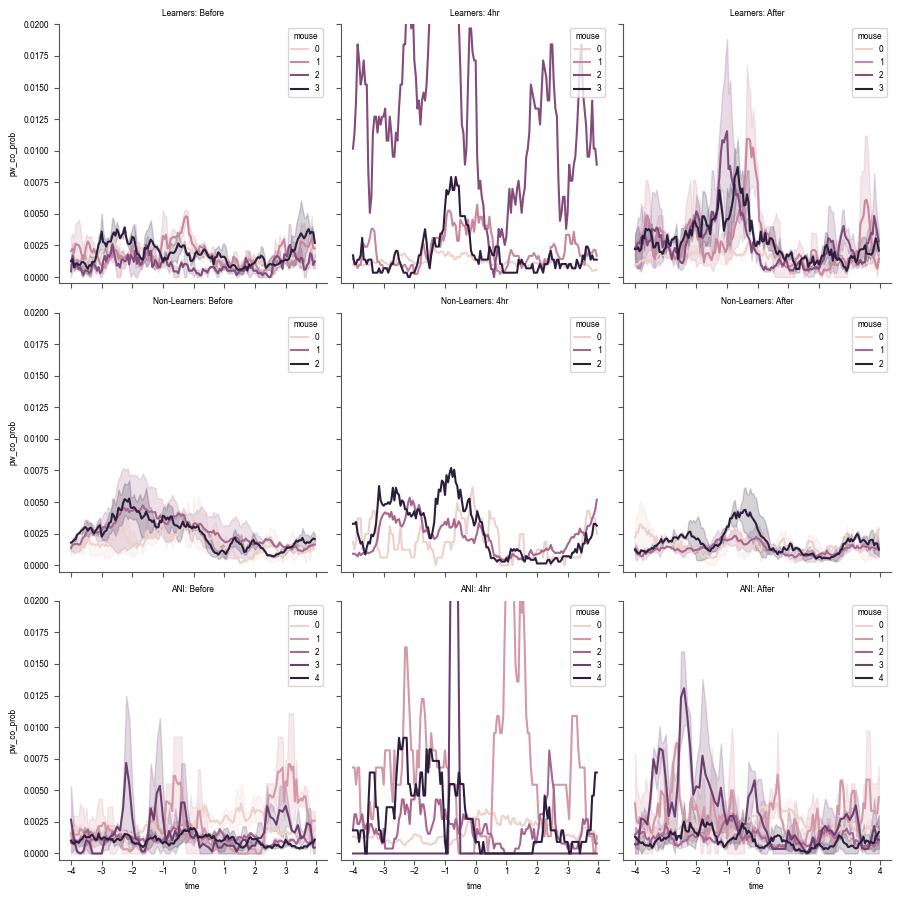

In [154]:
# plot pw coactivation broken down by mouse - shows that effect is consistent for all mice, in particular the Day 1 and Day 2 increase in
# pairwise coactivation probability
_, ax = plt.subplots(3, 3, figsize=(9, 9), sharey=True, sharex=True)
for arow, grp_df, grp_name in zip(ax, [lrn_df, nlrn_df, ani_df], ["Learners", "Non-Learners", "ANI"]):
    for a, desig in zip(arow, ["Before", "4hr", "After"]):
        sns.lineplot(data=grp_df[grp_df.Designation == desig], x="time", y="pw_co_prob", hue="mouse", ax=a)
        a.set_title(f"{grp_name}: {desig}")
        a.set_ylim([-0.0005, 0.02])

In [213]:
# Generate plots

# Create axes
ax_pw_cov_lrn, ax_pw_cov_lrn_stats = Fig3comb.subplot(Fig3.gs[4, 0])
ax_pw_cov_nlrn, ax_pw_cov_nlrn_stats = Fig3comb.subplot(Fig3.gs[4, 1])
ax_pw_cov_ani, ax_pw_cov_ani_stats = Fig3comb.subplot(Fig3.gs[4, 2])
# figt2, (ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani) = plt.subplots(1, 3, figsize=(9, 3))  # For testing out plots

# Plot
for a, df_use, gname in zip([ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani], [lrn_df, nlrn_df, ani_df], 
                            ['Learners', 'Non-Learners', 'ANI Group']):
    sns.lineplot(data=df_use, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"], 
                 ax=a, palette=sns.cubehelix_palette(n_colors=3), errorbar='se')
    # sns.lineplot(data=df_use[df_use.Designation != "4hr"], x='time',
    #              y='pw_co_prob', hue='Designation', hue_order=["Before", "After"], 
    #              ax=a, palette=sns.cubehelix_palette(n_colors=3))
    a.set_title(gname)


# Add labels and set axes equal
ylims_use = (-0.0005, 0.02)
for a in [ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani]:
    a.set_xlabel('Time from freeze onset (s)')
    a.set_ylabel('Prob. pairwise coactivation')
    a.set_ylim(ylims_use)

In [214]:
# Calculate stats: Mann-Whitney U-test between Before and 4hr/After at each time point
take_mean = True
func_name = "mwu" # str in ["wilcoxon", "mwu"]
func_use = getattr(pg, func_name)
statname = "U-val" if func_name == "mwu" else "W-val"
alpha = 0.05
p_lrn_ba, p_nlrn_ba, p_ani_ba = [], [], []
p_lrn_b4, p_nlrn_b4, p_ani_b4 = [], [], []
statval = []
for time_pt in np.unique(lrn_df.time):
        
    lrn_pts = lrn_df[lrn_df['time'] == time_pt]
    nlrn_pts = nlrn_df[nlrn_df['time'] == time_pt]
    ani_pts = ani_df[ani_df['time'] == time_pt]

    if take_mean:
        lrn_pts = lrn_pts.groupby(["Designation", "mouse"]).mean(numeric_only=True).reset_index()
        nlrn_pts = nlrn_pts.groupby(["Designation", "mouse"]).mean(numeric_only=True).reset_index()
        ani_pts = ani_pts.groupby(["Designation", "mouse"]).mean(numeric_only=True).reset_index()

    # Compare before to after
    stat_ba_lrn = func_use(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                         lrn_pts[lrn_pts['Designation'] == 'After']['pw_co_prob'],
                         alternative="less")
    stat_ba_nlrn = func_use(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                          nlrn_pts[nlrn_pts['Designation'] == 'After']['pw_co_prob'],
                          alternative="less")
    stat_ba_ani = func_use(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
                         ani_pts[ani_pts['Designation'] == 'After']['pw_co_prob'],
                         alternative="less")
    
    p_lrn_ba.append(stat_ba_lrn['p-val'].iloc[0])
    p_nlrn_ba.append(stat_ba_nlrn['p-val'].iloc[0])
    p_ani_ba.append(stat_ba_ani['p-val'].iloc[0]) 
    statval.append(stat_ba_nlrn[statname].iloc[0])
    
    # Compare before to 4 hour
    stat_b4_lrn = func_use(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                         lrn_pts[lrn_pts['Designation'] == '4hr']['pw_co_prob'],
                         alternative="less")
    stat_b4_nlrn = func_use(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                          nlrn_pts[nlrn_pts['Designation'] == '4hr']['pw_co_prob'],
                          alternative="less")
    stat_b4_ani = func_use(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
                         ani_pts[ani_pts['Designation'] == '4hr']['pw_co_prob'],
                         alternative="less")
    
    p_lrn_b4.append(stat_b4_lrn['p-val'].iloc[0])
    p_nlrn_b4.append(stat_b4_nlrn['p-val'].iloc[0])
    p_ani_b4.append(stat_b4_ani['p-val'].iloc[0])
    

In [215]:
# Plot stats as dots at top of coactivation plots
markertype, markersize, edgewidth = "_", 4, 2
palette = sns.cubehelix_palette(n_colors=3) 

for p_lrn_use, p_nlrn_use, p_ani_use, yadj, color_use in zip([p_lrn_b4, p_lrn_ba], [p_nlrn_b4, p_nlrn_ba],
                                                             [p_ani_b4, p_ani_ba], 
                                                             [0.93, 0.97], palette[-2:]):
    sig_bool_lrn = np.array(p_lrn_use) < alpha
    sig_bool_nlrn = np.array(p_nlrn_use) < alpha
    sig_bool_ani = np.array(p_ani_use) < alpha
    ax_pw_cov_lrn.plot(np.unique(lrn_df.time)[sig_bool_lrn], np.ones(sig_bool_lrn.sum())*yadj*ylims_use[1], 
                        markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
    ax_pw_cov_nlrn.plot(np.unique(nlrn_df.time)[sig_bool_nlrn], np.ones(sig_bool_nlrn.sum())*yadj*ylims_use[1], 
                        markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
    ax_pw_cov_ani.plot(np.unique(ani_df.time)[sig_bool_ani], np.ones(sig_bool_ani.sum())*yadj*ylims_use[1], 
                       markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)

#### For Neutral Arena - there is an increase from before to after, but it is much smaller and also does not occur during the 4 hour session

In [206]:
# Calculate pairwise activity and sort into before/during (4 hour)/after
# try:
#     coact_df_freeze4open = load_df("coact_df_freezeopen", save_dir=group_data_dir)
#     print("Previously saved data loaded")
# except FileNotFoundError:
coact_df_freeze4open = cova.gen_pw_coact('freeze_onset', buffer_sec=buffer_sec_use, buffer_sec_filt=buffer_sec_use, 
                                         arena="Open", cell_filt='freeze_cells', take_mean_across='session')
coact_df_freeze4open = add_memory_designations(coact_df_freeze4open, key_use='day',
                                           before=[-2, -1], during=[4], after=[1, 2])
save_df(coact_df_freeze4open, "coact_df_freezeopen", save_dir=group_data_dir)

# Now sort into groups
ctrl_df_open = coact_df_freeze4open[(coact_df_freeze4open['group'] == 'Learners') | 
                              (coact_df_freeze4open['group'] == 'Non-learners')]
ctrl_df_open.loc[:, 'day'] = ctrl_df_open['day'].astype(str)  # hack to make hue_order work

lrn_df_open = coact_df_freeze4open[(coact_df_freeze4open['group'] == 'Learners')]
lrn_df_open.loc[:, 'day'] = lrn_df_open['day'].astype(str)  # hack to make hue_order work
nlrn_df_open = coact_df_freeze4open[(coact_df_freeze4open['group'] == 'Non-learners')]
nlrn_df_open.loc[:, 'day'] = nlrn_df_open['day'].astype(str)  # hack to make hue_order work
ani_df_open = coact_df_freeze4open[coact_df_freeze4open['group'] == 'ANI']
ani_df_open.loc[:, 'day'] = ani_df_open['day'].astype(str)  # hack to make hue_order work

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181126_1_openfield: nbadpts = 18 max_in_a_row = 3
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
/Users/nkinsky/Documents/BU/Working/Eraser/Anisomycin Group/Marble25/20181203_1_openfield: nbadpts = 9 max_in_a_row = 6
coact_df_freezeopen.csv saved


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/1134601290.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['-2' '-2' '-2' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ctrl_df_open.loc[:, 'day'] = ctrl_df_open['day'].astype(str)  # hack to make hue_order work
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/1134601290.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['-2' '-2' '-2' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lrn_df_open.loc[:, 'day'] = lrn_df_open['day'].astype(str)  # hack to make hue_order work
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_32864/1134601290.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a 

In [216]:
take_mean = True
func_name = "mwu" # str in ["wilcoxon", "mwu"]
func_use = getattr(pg, func_name)
statname = "U-val" if func_name == "mwu" else "W-val"
alpha = 0.05
p_lrn_ba, p_nlrn_ba, p_ani_ba = [], [], []
p_lrn_b4, p_nlrn_b4, p_ani_b4 = [], [], []
statval = []
for time_pt in np.unique(lrn_df.time):
        
    lrn_pts = lrn_df[lrn_df['time'] == time_pt]
    nlrn_pts = nlrn_df[nlrn_df['time'] == time_pt]
    ani_pts = ani_df[ani_df['time'] == time_pt]

    if take_mean:
        lrn_pts = lrn_pts.groupby(["Designation", "mouse"]).mean(numeric_only=True).reset_index()
        nlrn_pts = nlrn_pts.groupby(["Designation", "mouse"]).mean(numeric_only=True).reset_index()
        ani_pts = ani_pts.groupby(["Designation", "mouse"]).mean(numeric_only=True).reset_index()

    # Compare before to after
    stat_ba_lrn = func_use(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                         lrn_pts[lrn_pts['Designation'] == 'After']['pw_co_prob'],
                         alternative="less")
    stat_ba_nlrn = func_use(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                          nlrn_pts[nlrn_pts['Designation'] == 'After']['pw_co_prob'],
                          alternative="less")
    stat_ba_ani = func_use(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
                         ani_pts[ani_pts['Designation'] == 'After']['pw_co_prob'],
                         alternative="less")
    
    p_lrn_ba.append(stat_ba_lrn['p-val'].iloc[0])
    p_nlrn_ba.append(stat_ba_nlrn['p-val'].iloc[0])
    p_ani_ba.append(stat_ba_ani['p-val'].iloc[0]) 
    statval.append(stat_ba_nlrn[statname].iloc[0])
    
    # Compare before to 4 hour
    stat_b4_lrn = func_use(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                         lrn_pts[lrn_pts['Designation'] == '4hr']['pw_co_prob'],
                         alternative="less")
    stat_b4_nlrn = func_use(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
                          nlrn_pts[nlrn_pts['Designation'] == '4hr']['pw_co_prob'],
                          alternative="less")
    stat_b4_ani = func_use(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
                         ani_pts[ani_pts['Designation'] == '4hr']['pw_co_prob'],
                         alternative="less")
    
    p_lrn_b4.append(stat_b4_lrn['p-val'].iloc[0])
    p_nlrn_b4.append(stat_b4_nlrn['p-val'].iloc[0])
    p_ani_b4.append(stat_b4_ani['p-val'].iloc[0])

In [ ]:
# Calculate stats: Mann-Whitney U-test between Before and 4hr/After at each time point
# alpha = 0.01
# p_lrn_ba, p_nlrn_ba, p_ani_ba = [], [], []
# p_lrn_b4, p_nlrn_b4, p_ani_b4 = [], [], []
# uval = []
# for time_pt in np.unique(lrn_df_open.time):
#     lrn_pts = lrn_df_open[lrn_df_open['time'] == time_pt]
#     nlrn_pts = nlrn_df_open[nlrn_df_open['time'] == time_pt]
#     ani_pts = ani_df_open[ani_df_open['time'] == time_pt]

#     # Compare before to after
#     stat_ba_lrn = pg.mwu(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
#                          lrn_pts[lrn_pts['Designation'] == 'After']['pw_co_prob'],
#                          alternative="less")
#     stat_ba_nlrn = pg.mwu(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
#                           nlrn_pts[nlrn_pts['Designation'] == 'After']['pw_co_prob'],
#                           alternative="less")
#     stat_ba_ani = pg.mwu(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
#                          ani_pts[ani_pts['Designation'] == 'After']['pw_co_prob'],
#                          alternative="less")
#     p_lrn_ba.append(stat_ba_lrn['p-val'].iloc[0])
#     p_nlrn_ba.append(stat_ba_nlrn['p-val'].iloc[0])
#     p_ani_ba.append(stat_ba_ani['p-val'].iloc[0]) 
#     uval.append(stat_ba_nlrn['U-val'].iloc[0])
    
#     # Compare before to 4 hour
#     stat_b4_lrn = pg.mwu(lrn_pts[lrn_pts['Designation'] == 'Before']['pw_co_prob'], 
#                          lrn_pts[lrn_pts['Designation'] == '4hr']['pw_co_prob'],
#                          alternative="less")
#     stat_b4_nlrn = pg.mwu(nlrn_pts[nlrn_pts['Designation'] == 'Before']['pw_co_prob'], 
#                           nlrn_pts[nlrn_pts['Designation'] == '4hr']['pw_co_prob'],
#                           alternative="less")
#     stat_b4_ani = pg.mwu(ani_pts[ani_pts['Designation'] == 'Before']['pw_co_prob'],
#                          ani_pts[ani_pts['Designation'] == '4hr']['pw_co_prob'],
#                          alternative="less")
    
#     p_lrn_b4.append(stat_b4_lrn['p-val'].iloc[0])
#     p_nlrn_b4.append(stat_b4_nlrn['p-val'].iloc[0])
#     p_ani_b4.append(stat_b4_ani['p-val'].iloc[0])
    

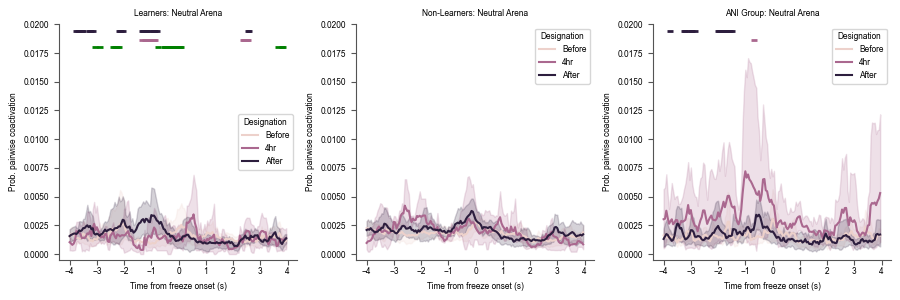

In [217]:
# Plot

for idr in range(2):
    # Create axes
    if idr == 0:
        _, (ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani) = plt.subplots(1, 3, figsize=(9, 3))
    else:
        ax_pw_cov_lrn, ax_pw_cov_lrn_stats = FigS6comb.subplot(FigS6.gs[5, 0])
        ax_pw_cov_nlrn, ax_pw_cov_nlrn_stats = FigS6comb.subplot(FigS6.gs[5, 1])
        ax_pw_cov_ani, ax_pw_cov_ani_stats = FigS6comb.subplot(FigS6.gs[5, 2])


    # Plot
    for a, df_use, gname in zip([ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani], [lrn_df_open, nlrn_df_open, ani_df_open], 
                                ['Learners', 'Non-Learners', 'ANI Group']):
        sns.lineplot(data=df_use, x='time', y='pw_co_prob', hue='Designation', hue_order=["Before", "4hr", "After"], 
                     ax=a, palette=sns.cubehelix_palette(n_colors=3))
        a.set_title(f"{gname}: Neutral Arena")
    
    
    # Add labels and set axes equal
    ylims_use = (-0.0005, 0.02)
    for a in [ax_pw_cov_lrn, ax_pw_cov_nlrn, ax_pw_cov_ani]:
        a.set_xlabel('Time from freeze onset (s)')
        a.set_ylabel('Prob. pairwise coactivation')
        a.set_ylim(ylims_use)

    # Plot stats as dots at top of coactivation plots
    markertype, markersize, edgewidth = "_", 4, 2
    palette = sns.cubehelix_palette(n_colors=3) 
    
    for p_lrn_use, p_nlrn_use, p_ani_use, yadj, color_use in zip([p_lrn_b4, p_lrn_ba], [p_nlrn_b4, p_nlrn_ba],
                                                             [p_ani_b4, p_ani_ba], 
                                                             [0.93, 0.97], palette[-2:]):
        sig_bool_lrn = np.array(p_lrn_use) < alpha
        sig_bool_nlrn = np.array(p_nlrn_use) < alpha
        sig_bool_ani = np.array(p_ani_use) < alpha
        ax_pw_cov_lrn.plot(np.unique(lrn_df.time)[sig_bool_lrn], np.ones(sig_bool_lrn.sum())*yadj*ylims_use[1], 
                            markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
        ax_pw_cov_nlrn.plot(np.unique(nlrn_df.time)[sig_bool_nlrn], np.ones(sig_bool_nlrn.sum())*yadj*ylims_use[1], 
                            markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
        ax_pw_cov_ani.plot(np.unique(ani_df.time)[sig_bool_ani], np.ones(sig_bool_ani.sum())*yadj*ylims_use[1], 
                           markertype, color=color_use, markersize=markersize, markeredgewidth=edgewidth)
    
    if idr == 0:  # Plot between arena coactivation diffs for ref - shock coactivation much higher than open!
        p_bw_arenas_after = []
        for time_pt in np.unique(lrn_df_open.time):
            lrn_pts_open = lrn_df_open[lrn_df_open['time'] == time_pt]
            lrn_pts = lrn_df[lrn_df['time'] == time_pt]
            stat_ba_lrn_bw = pg.mwu(lrn_pts_open[lrn_pts_open['Designation'] == 'After']['pw_co_prob'], 
                                 lrn_pts[lrn_pts['Designation'] == 'After']['pw_co_prob'],
                                 alternative="less")
            p_bw_arenas_after.append(stat_ba_lrn_bw['p-val'].iloc[0])
        
        sig_bool_bw = np.array(p_bw_arenas_after) < alpha
        yadj=0.9
        ax_pw_cov_lrn.plot(np.unique(lrn_df.time)[sig_bool_bw], np.ones(sig_bool_bw.sum())*yadj*ylims_use[1], 
                                markertype, color='g', markersize=markersize, markeredgewidth=edgewidth)


In [ ]:
# Plot Learners in Neutral Arena with Shock arena After overlaid for reference
# Shows that pairwise coactivation is much larger and more sustained in shock arena compared to neutral arena
_, ax = plt.subplots(figsize=(3, 3))
lrn_df_open = coact_df_freeze4open[(coact_df_freeze4open['group'] == 'Learners')]
lrn_df_open.loc[:, 'day'] = lrn_df_open['day'].astype(str)  # hack to make hue_order work

lrn_df = coact_df_freeze4[(coact_df_freeze4['group'] == 'Learners')]
lrn_df.loc[:, 'day'] = lrn_df['day'].astype(str)  # hack to make hue_order work
sns.lineplot(data=lrn_df_open[lrn_df_open.Designation == "After"], x='time', y='pw_co_prob', 
             ax=ax, palette=sns.cubehelix_palette(n_colors=3))
sns.lineplot(data=lrn_df[lrn_df.Designation == "After"], x='time', y='pw_co_prob',
             ax=ax, errorbar=None, linestyle='--')
ax.set_ylim((-0.0005, 0.02))

## Plot proportion of freeze cells with significant pairwise coactivation after accounting for increased firing rate.

In [ ]:
# Generate pairwise coactivation statistics by comparing actual pairwise coactivation to what we observe
# after trial shuffling (chance).

try:
    pw_co_df_all = load_df("sig_pairwise_co_all", save_dir=group_data_dir)
    print("Previously saved data successfully loaded")
except FileNotFoundError:
    group_name_list, pw_sig_prop_frz, day_list = [], [], []
    days = [-2, -1, 4, 1, 2]
    buffer_sec = (4, 4)
    nshifts = 1000 # number of trial shifts to perform
    alpha = 0.05  # significance level
    nbins = 3  # must be below alpha for greater than this many CONSECUTIVE bins to be considered signicantly coupled
    
    pw_co_df_all = []
    for gname, group in zip(['Learners', 'Non-Learners', 'ANI'], [err.learners, err.nonlearners, err.ani_mice_good]):
        print(f"Running pairwise covariance analysis for {gname} group")
        for day in tqdm(days):
            for mouse in group:
                pwco = cova.PairwiseCoactivation(mouse, 'Shock', day, buffer_sec=buffer_sec_use)
                pval, sigbool = pwco.calc_pw_significance(nshifts=nshifts, alpha=alpha, nbins=nbins, )
                pw_sig_prop_frz.append(sigbool.sum() / len(sigbool))
                nneurons = pwco.MD.PSAbool.shape[0]
                day_list.append(day)
                group_name_list.append(gname)
    
                pw_co_df_all.append(pd.DataFrame({"Group": gname, "Day": day, "Mouse": mouse, "sig_cov_bool": sigbool}))
    
    # tidy things up
    pw_co_df = pd.DataFrame({"Group": group_name_list, "Day": day_list, "pw_frz_sig_prop": pw_sig_prop_frz})
    pw_co_df = add_memory_designations(pw_co_df, key_use="Day", before=[-2, -1], during=[4], after=[1, 2])
    
    pw_co_df_all = pd.concat(pw_co_df_all, axis=0)
    pw_co_df_all = add_memory_designations(pw_co_df_all, key_use="Day", before=[-2, -1], during=[4], after=[1, 2])
    
    # Sanity check to make you sure you get the same results for sig. covar. proportions for both methods above.
    _, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    pw_co_df_mean = pw_co_df_all.drop(columns="Designation").groupby(["Group", "Day", "Mouse"]).apply(lambda x: x.sum() / len(x)).reset_index()
    pw_co_df_mean = add_memory_designations(pw_co_df_mean, key_use="Day", before=[-2, -1], during=[4], after=[1, 2])
    pw_co_df_mean["Group"] = pd.Categorical(pw_co_df_mean["Group"], ["Learners", "Non-Learners", "ANI"])
    pw_co_df_mean["Designation"] = pd.Categorical(pw_co_df_mean["Designation"], ["Before", "4hr", "After"])
    
    
    sns.stripplot(data=pw_co_df_mean, x="Designation", y="sig_cov_bool", hue="Group", dodge=True, ax=ax[0])
    sns.stripplot(data=pw_co_df, x="Designation", y="pw_frz_sig_prop", hue="Group", dodge=True, ax=ax[1])
    
    # Save all significant pairwise coactivations in a dataframe
    save_df(pw_co_df_all, "sig_pairwise_co_all", save_dir=group_data_dir)

In [ ]:
ax_pw_cov_prop, ax_pw_cov_prop_stats = Fig3comb.subplot(Fig3.gs[4, 3])
# # For testing out plot aesthetics quickly
# fpw_prop, ax_pw_prop = plt.subplots(1, 2, figsize=(4, 2))
# ax_pw_cov_prop, ax_pw_cov_prop_stats = ax_pw_prop

pw_co_df_all = load_df("sig_pairwise_co_all", save_dir=group_data_dir)
pw_co_df_mean = pw_co_df_all.drop(columns="Designation").groupby(["Group", "Day", "Mouse"]).apply(lambda x: x.sum() / len(x)).reset_index()
pw_co_df_mean = add_memory_designations(pw_co_df_mean, key_use="Day", before=[-2, -1], during=[4], after=[1, 2], designation_key="Epoch")
pw_co_df_mean["Group"] = pd.Categorical(pw_co_df_mean["Group"], ["Learners", "Non-Learners", "ANI"])
pw_co_df_mean["Epoch"] = pd.Categorical(pw_co_df_mean["Epoch"], ["Before", "4hr", "After"])
df_mean = pw_co_df_mean
df_boot = load_df("sig_pairwise_co_boot", save_dir=group_data_dir)

cmap_use = plt.get_cmap('Set2').colors[0:3]
whis = (2.5, 97.5)

for idr in range(2):  # Plot twice - once to output figures, once below for reference
    if idr == 0:
        axs = [ax_pw_cov_prop, ax_pw_cov_prop_stats]
    else:
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    ax, axstats = axs
    
    pal_use = sns.color_palette(palette='Set2', as_cmap=False)  
    sns.boxplot(data=df_boot, x="Epoch", y="sig_cov_bool", hue="Group", showfliers=False, fill=False, 
                linewidth=0.5, palette=pal_use, legend=legend, whis=whis, ax=ax)
    sns.stripplot(data=df_mean, x="Epoch", y="sig_cov_bool", hue="Group", dodge=True, palette=pal_use, 
                  size=3, linewidth=0.2, edgecolor='w', ax=ax, legend=False)
    ax.set_ylabel("Proportion Coactive", fontsize=8)
    ax.set_xlabel('', fontsize=8)
    ax.set_title("Freeze Cell Pairwise Coactivation")
    
    axstats.set_title(f"{title} Stats")
    y = 1
    axstats.set_title("Freeze Cell Pairwise Coact. Prop.")
    for group in ["Learners", "Non-Learners", "ANI"]:
        y -= 0.1
        df_grp = df_boot[df_boot.Group == group]
        
        comps = [["Before", "4hr"], ["Before", "After"]]
        for comp in comps:
            bootstat, pboot = get_bootstrap_prob(df_grp[df_grp.Epoch == comp[0]].sig_cov_bool, df_grp[df_grp.Epoch == comp[1]].sig_cov_bool)
            axstats.text(0.1, y, f"{group} {comp[0]} vs {comp[1]} HB p-val (one-sided) = {pboot:0.3g}")
            y -= 0.1
    
    [sns.despine(ax=a) for a in axs];

In [218]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')

Fig3.savefig(plot_path / 'Figure3.pdf', scriptname='Figure3.ipynb')
Fig3stats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3.ipynb')

FigS6.savefig(plot_path / 'FigureS6.pdf', scriptname='Figure3.ipynb')
FigS6stats.savefig(plot_path / 'FigureS6stats.pdf', scriptname='Figure3.ipynb')